In [1]:
import pandas as pd
import pyarrow
#from GenSmoothScatter import smooth_scatter
import os

# Configurable arguments
ROOT_DIR = "../data/ehan31/hannum/raw"  # Root directory for all data

# Define data reading function
def read_arrow_data(file, path=ROOT_DIR+"/"):
    filepath = path + file
    #print(os.path.isfile(path + file))
    #with open(path + file, 'rb') as f:
    data_df = pd.read_feather(filepath)
    return data_df


# Read in data
os.makedirs(ROOT_DIR, exist_ok=True)

age_df = read_arrow_data(file="metadata/metadata.arrow")
#age_df.head()
print(age_df.columns)

beta_df = read_arrow_data(file="betas/gse_betas.arrow") #NOTE: This requires 70+ GB Ram
beta_df.head()

Index(['title', 'geo_accession', 'status', 'submission_date',
       'last_update_date', 'type', 'channel_count', 'source_name_ch1',
       'organism_ch1', 'taxid_ch1', 'molecule_ch1', 'extract_protocol_ch1',
       'label_ch1', 'label_protocol_ch1', 'hyb_protocol', 'scan_protocol',
       'description', 'data_processing', 'platform_id', 'contact_name',
       'contact_email', 'contact_institute', 'contact_address', 'contact_city',
       'contact_state', 'contact_zip/postal_code', 'contact_country',
       'supplementary_file', 'series_id', 'data_row_count', 'age (y)',
       'source', 'plate', 'gender', 'ethnicity', 'tissue'],
      dtype='object')


,cg13869341,cg14008030,cg12045430,cg20826792,cg00381604,cg20253340,cg21870274,cg03130891,cg24335620,cg16162899,...,cg27124406,cg19565306,cg22012975,cg10353737,cg22531257,cg22662321,cg06996138,cg16817496,cg07660283,cg09226288
GSM989827,0.849261,0.505916,0.072590,0.186961,0.036803,0.661391,0.777891,0.119538,0.782193,0.905126,...,0.079514,0.003605,0.016267,0.058144,0.016545,0.044135,0.021236,0.291702,0.727581,0.705499
GSM989828,0.897434,0.476842,0.079020,0.228201,0.053161,0.545065,0.776407,0.063938,0.787890,0.913628,...,0.080328,0.004043,0.008628,0.044876,0.014927,0.058587,0.019314,0.232008,0.693993,0.716328
GSM989829,0.751596,0.487245,0.089230,0.237660,0.045588,0.560305,0.774234,0.113279,0.788896,0.914348,...,0.079417,0.003508,0.004635,0.041357,0.024015,0.058990,0.016854,0.296456,0.703291,0.703523
GSM989830,0.871313,0.466692,0.076666,0.253624,0.032824,0.509904,0.772503,0.067163,0.800081,0.882308,...,0.080837,0.005296,0.006407,0.041691,0.030413,0.064237,0.019278,0.270818,0.751772,0.696888
GSM989831,0.775703,0.490255,0.079986,0.220404,0.035804,0.549847,0.730345,0.131637,0.759171,0.902783,...,0.084922,0.016451,0.007065,0.060183,0.015760,0.064953,0.016097,0.236963,0.746697,0.693056


In [14]:
# #Grab a few columns from beta df for testing (rows from both dfs are sorted by index so can convert directly to numpy)
# Currently using the first 50 out of 353 methylation sites from the Horvath Clock
df_methylation_sites = pd.read_csv("./coefficients.csv")['CpGmarker'][1:50]
list_of_methylation_sites = list(df_methylation_sites)[1:50]
age_v = age_df['age (y)'].to_numpy(dtype=int)
beta_v = beta_df[list_of_methylation_sites].to_numpy()

## Plot and save images
from GenSmoothScatter import smooth_scatter

# Create and save images for each methylation site
filepath = "../data/ehan31/hannum/processed/images/"  
for i in range(len(list_of_methylation_sites)):
    smooth_scatter(age_v, beta_v[:, i], filename=filepath+list_of_methylation_sites[i], marker_size=0) # This takes forever :(

KeyboardInterrupt: 

In [21]:
# Create a custom dataset
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
from moviepy.video.io.bindings import mplfig_to_npimage # This package is the fastest way I've found to turn figs to np arrays
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

## Code from OvO Attention!
class MethylationAgeDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.root_dir = root_dir
    
    def __len__(self):
        # Return the length of the dataset
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        # Return the observation based on an index
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = self.dataframe.iloc[idx]

        image = Image.open(os.path.join(self.root_dir + img_name + ".jpg"))
        image = image.convert('L')
        image = np.asarray(image, dtype=np.uint8)

        if self.transform:
            image = self.transform(image)
    
        return image
    
    

# Enter into the dataset the df of ids for the images as well as the transformations we will perform
dataset = MethylationAgeDataset(
    dataframe=df_methylation_sites,
    root_dir=filepath,
    transform=transforms.ToTensor()
)

# Define dataloader
BATCH_SIZE = 4
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

# Code to save data
TENSOR_PATH = "../data/ehan31/hannum/processed/tensors/"
path = TENSOR_PATH + "inputs.pt"
#torch.save(data, path)

In [34]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

# Define Basic Autoencoder model
class Autoencoder(nn.Module):

    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.activation = F.leaky_relu
        
        # Encoder
        # TODO: Parameter tuning
        self.conv1 = nn.Conv2d(1, 4, 4, stride=3)
        self.conv2 = nn.Conv2d(4, 8, 4, stride=3)
        self.conv3 = nn.Conv2d(8, 16, 4, stride=3)

        # Decoder
        # TODO: Considering just making the graph a square, the output padding is messing with model
        self.convT1 = nn.ConvTranspose2d(16, 8, 4, stride=3, output_padding=[1,1])
        self.convT2 = nn.ConvTranspose2d(8, 4, 4, stride=3, output_padding=[2,0])
        self.convT3 = nn.ConvTranspose2d(4, 1, 4, stride=3, output_padding=[2,0])


    def forward(self, x):
        # Encode
        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))
        x = self.activation(self.conv3(x))

        # Decode
        x = self.activation(self.convT1(x))
        x = self.activation(self.convT2(x))
        x = F.sigmoid(self.convT3(x))
        return x

model = Autoencoder()
print(model)

# Define losses and optimizer
# TODO: Explore different loss functions
mse_loss_fn = nn.MSELoss()
bce_loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Autoencoder(
  (conv1): Conv2d(1, 4, kernel_size=(4, 4), stride=(3, 3))
  (conv2): Conv2d(4, 8, kernel_size=(4, 4), stride=(3, 3))
  (conv3): Conv2d(8, 16, kernel_size=(4, 4), stride=(3, 3))
  (convT1): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(3, 3), output_padding=(1, 1))
  (convT2): ConvTranspose2d(8, 4, kernel_size=(4, 4), stride=(3, 3), output_padding=(2, 0))
  (convT3): ConvTranspose2d(4, 1, kernel_size=(4, 4), stride=(3, 3), output_padding=(2, 0))
)


In [42]:
def train_loop(dataloader, model, optimizer, loss_fns=None):
    size = len(dataloader.dataset)
    
    model.train()
    for batch, X in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        
        # Manually using combination of MSE and CE for reconstruction loss
        mse_loss = mse_loss_fn(pred, X)
        bce_loss = bce_loss_fn(pred, X)
        loss = 10 * mse_loss + bce_loss # TODO: Constant here will be tweaked

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 2 * BATCH_SIZE == 0:
            loss, current = loss.item(), batch * BATCH_SIZE + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(dataloader, model, optimizer)

Epoch 1
-------------------------------
loss: 0.428584  [    4/   49]
loss: 0.393863  [   12/   49]
loss: 0.428997  [   20/   49]
loss: 0.402622  [   28/   49]
loss: 0.392930  [   36/   49]
loss: 0.332035  [   44/   49]
loss: 0.489292  [   49/   49]
Epoch 2
-------------------------------
loss: 0.425520  [    4/   49]
loss: 0.390286  [   12/   49]
loss: 0.425633  [   20/   49]
loss: 0.398847  [   28/   49]
loss: 0.388992  [   36/   49]
loss: 0.327562  [   44/   49]
loss: 0.486715  [   49/   49]
Epoch 3
-------------------------------
loss: 0.422237  [    4/   49]
loss: 0.386437  [   12/   49]
loss: 0.422134  [   20/   49]
loss: 0.394781  [   28/   49]
loss: 0.384870  [   36/   49]
loss: 0.322887  [   44/   49]
loss: 0.483413  [   49/   49]
Epoch 4
-------------------------------
loss: 0.418281  [    4/   49]
loss: 0.381869  [   12/   49]
loss: 0.418007  [   20/   49]
loss: 0.390001  [   28/   49]
loss: 0.380096  [   36/   49]
loss: 0.318265  [   44/   49]
loss: 0.479197  [   49/   49]


tensor([0.7356, 0.9590, 0.9596, 0.9905, 0.9944, 0.9874, 0.9942, 0.9885, 0.9828,
        0.9931, 0.9985, 0.9986, 0.9994, 0.9984, 0.9956, 0.9984, 0.9961, 0.9936,
        0.9973, 0.9992, 0.9994, 0.9996, 0.9987, 0.9961, 0.9986, 0.9966, 0.9945,
        0.9987, 0.9999, 0.9999, 1.0000, 0.9999, 0.9997, 0.9999, 0.9998, 0.9995,
        0.9998, 0.9999, 0.9999, 0.9999, 0.9984, 0.9956, 0.9984, 0.9961, 0.9936,
        0.9973, 0.9992, 0.9994, 0.9996, 0.9987, 0.9961, 0.9986, 0.9966, 0.9945,
        0.9987, 0.9999, 0.9999, 1.0000, 0.9999, 0.9997, 0.9999, 0.9998, 0.9995,
        0.9998, 0.9999, 0.9999, 0.9999, 0.9984, 0.9956, 0.9984, 0.9961, 0.9936,
        0.9973, 0.9992, 0.9994, 0.9996, 0.9987, 0.9961, 0.9986, 0.9966, 0.9945,
        0.9987, 0.9999, 0.9999, 1.0000, 0.9999, 0.9997, 0.9999, 0.9998, 0.9995,
        0.9998, 0.9999, 0.9999, 0.9999, 0.9984, 0.9956, 0.9984, 0.9961, 0.9936,
        0.9973, 0.9992, 0.9994, 0.9996, 0.9987, 0.9961, 0.9986, 0.9966, 0.9945,
        0.9987, 0.9999, 0.9999, 1.0000, 

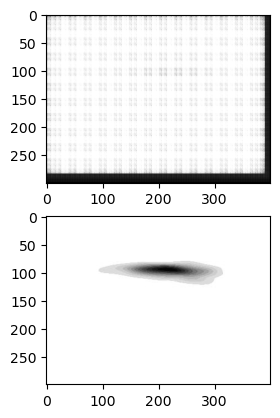

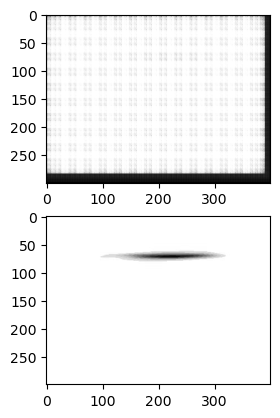

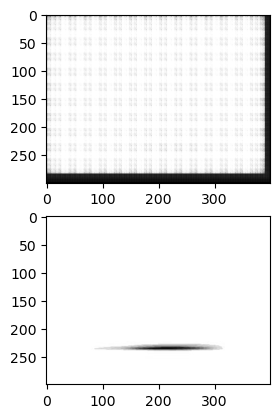

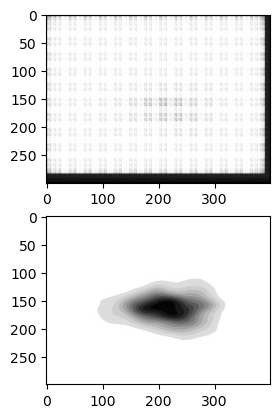

In [43]:
# Examine example images
example_x = next(iter(dataloader))
with torch.no_grad():
    outputs = model(example_x)

# NOTE: These images have been trained on before
for i, image in enumerate(outputs):
    f, axarr = plt.subplots(2,1)
    axarr[0].imshow(image[0],cmap='gray')
    axarr[1].imshow(example_x[i][0],cmap='gray')
    plt.show()
    plt.close()

In [ ]:
from sklearn.manifold import TSNE

num_samples = 49

# Get embeddings for num_samples
with torch.no_grad():
    x = model.activation(model.conv1(X[-num_samples:]))
    x = model.activation(model.conv2(x))
    z = model.activation(model.conv3(x))
    
z = np.reshape(z, [num_samples, -1])

# Map samples into 2D vector space
tsne = TSNE(n_components=2, learning_rate='auto', init='random')
transformed = tsne.fit_transform(z)
colors = L0[-num_samples:]
plt.scatter(transformed[:, 0], transformed[:, 1], c=colors)
plt.colorbar()
plt.show()